<a href="https://colab.research.google.com/github/Brymer-Meneses/COVID19-AI-CT-Scan-Detection/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import tensorflow_hub as hub

import os 
import shutil
from zipfile import ZipFile
from tqdm.notebook import tqdm

from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np


# Prerequisites

In [ ]:
path = '/content/drive/My Drive/External Datasets/COVID19-Project/Datasets/main_dataset.zip'

file = ZipFile(path, 'r')
file.extractall()

In [ ]:
test_dir = '/content/main/test'
train_dir = '/content/main/train'
val_dir = '/content/main/validation'

In [ ]:
#  EfficientNet-Lite4
img_height = 380
img_width = 380

batch_size = 64

In [ ]:
#  Xception
img_height = 512
img_width = 512

batch_size = 64

In [ ]:
datagen = ImageDataGenerator(horizontal_flip = True, rescale = (1/255))

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)


test_gen = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size,
)


val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)

Found 12789 images belonging to 3 classes.
Found 3173 images belonging to 3 classes.
Found 6350 images belonging to 3 classes.


In [ ]:
class_names = ['covid', 'non-covid', 'non-informative']

# Training the model

In [ ]:
URL = 'https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2'
pretrained_model = hub.KerasLayer(URL, input_shape = (img_height, img_width,3))

In [ ]:
pretrained_model = tf.keras.applications.Xception(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (img_height, img_width, 3),
                                                  )
pretrained_model.trainable = False

In [ ]:
model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(.30))
model.add(Dense(3, activation = 'softmax'))


In [ ]:
model.compile(optimizer = Adamax(), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience =3)

In [ ]:
history = model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
200/200 [==============================] - 246s 1s/step - loss: 0.4179 - accuracy: 0.7752 - val_loss: 0.3105 - val_accuracy: 0.8710
Epoch 2/5
200/200 [==============================] - 237s 1s/step - loss: 0.3432 - accuracy: 0.8177 - val_loss: 0.1434 - val_accuracy: 0.9526
Epoch 3/5
200/200 [==============================] - 236s 1s/step - loss: 0.3241 - accuracy: 0.8243 - val_loss: 0.1198 - val_accuracy: 0.9605
Epoch 4/5
200/200 [==============================] - 236s 1s/step - loss: 0.3118 - accuracy: 0.8363 - val_loss: 0.1677 - val_accuracy: 0.9372


In [ ]:
history1 = model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
200/200 [==============================] - 239s 1s/step - loss: 0.2934 - accuracy: 0.8428 - val_loss: 0.0997 - val_accuracy: 0.9665
Epoch 2/5
200/200 [==============================] - 235s 1s/step - loss: 0.2849 - accuracy: 0.8504 - val_loss: 0.0613 - val_accuracy: 0.9798
Epoch 3/5
200/200 [==============================] - 234s 1s/step - loss: 0.2821 - accuracy: 0.8532 - val_loss: 0.1092 - val_accuracy: 0.9624
Epoch 4/5
200/200 [==============================] - 234s 1s/step - loss: 0.2779 - accuracy: 0.8533 - val_loss: 0.0834 - val_accuracy: 0.9734
Epoch 5/5
200/200 [==============================] - 234s 1s/step - loss: 0.2739 - accuracy: 0.8541 - val_loss: 0.0750 - val_accuracy: 0.9751


In [ ]:
metrics = model.evaluate(test_gen)

50/50 [==============================] - 41s 816ms/step - loss: 0.0677 - accuracy: 0.9732


In [ ]:
model.trainable = True

In [ ]:
os.mkdir('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models/model_checkpoints')

In [ ]:
model.save('EfficientNet-L4-v1.h5')

In [ ]:
history2 = model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
200/200 [==============================] - 240s 1s/step - loss: 0.2753 - accuracy: 0.8525 - val_loss: 0.0558 - val_accuracy: 0.9805
Epoch 2/5
200/200 [==============================] - 241s 1s/step - loss: 0.2691 - accuracy: 0.8589 - val_loss: 0.0724 - val_accuracy: 0.9765
Epoch 3/5
200/200 [==============================] - 237s 1s/step - loss: 0.2702 - accuracy: 0.8548 - val_loss: 0.0657 - val_accuracy: 0.9776
Epoch 4/5
200/200 [==============================] - 238s 1s/step - loss: 0.2651 - accuracy: 0.8597 - val_loss: 0.0524 - val_accuracy: 0.9824
Epoch 5/5
200/200 [==============================] - 238s 1s/step - loss: 0.2653 - accuracy: 0.8611 - val_loss: 0.0688 - val_accuracy: 0.9775


In [ ]:
model.evaluate(test_gen)

50/50 [==============================] - 42s 831ms/step - loss: 0.0569 - accuracy: 0.9795


[0.05691893398761749, 0.9795146584510803]

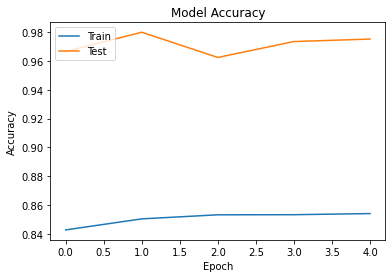

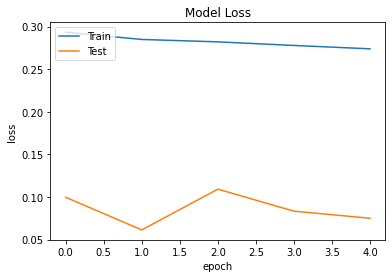

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc = 'upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
os.chdir('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models')
model.save('EfficientNet-Lite4-v3.h5')

# Conversion to TFlite Model

In [ ]:
data_aug = Sequential([
  Resizing(img_height, img_width, interpolation= 'bilinear'),
  Rescaling(1/255)
], name = 'data_augmentation')

In [ ]:
model.trainable = False

In [ ]:
full_model = Sequential()
full_model.add(data_aug)
full_model.add(model)

In [ ]:
full_model.compile(loss = 'categorical_crossentropy', optimizer = Adam())

In [ ]:
full_model.fit(train_gen) #Necessary to build the model. Stopped early.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(full_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpy3v8__u_/assets


INFO:tensorflow:Assets written to: /tmp/tmpy3v8__u_/assets


In [ ]:
with open('COVID19-Model-v3.tflite', 'wb') as f:
  f.write(tflite_model)

# Plotting the confusion matrix

In [ ]:
model = load_model('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models/Xception-v2.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              13118936  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 13,632,987
Trainable params: 514,051
Non-trainable params: 13,118,936
_________________________________________________________________


In [ ]:
predictions = model.predict(test_gen)

In [ ]:
print(predictions)

[[9.9883527e-01 1.1647776e-03 1.6515502e-08]
 [9.9984229e-01 1.0673636e-04 5.0854847e-05]
 [9.9995923e-01 4.0741015e-05 5.6047192e-08]
 ...
 [1.0513102e-09 2.2349550e-05 9.9997771e-01]
 [1.3789391e-09 2.4952024e-06 9.9999750e-01]
 [1.0949808e-09 1.4025403e-02 9.8597461e-01]]


In [ ]:
rounded_predictions = np.argmax(predictions, axis =1)

In [ ]:
labels = test_gen.classes


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


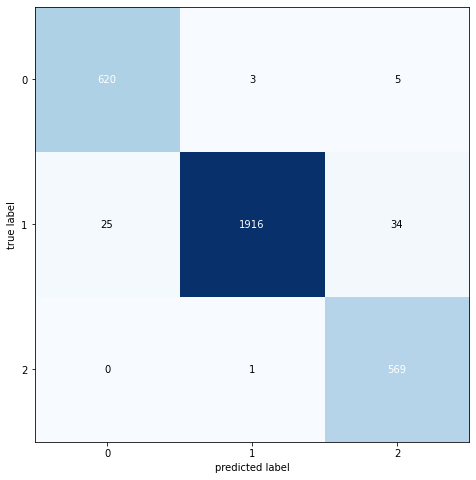

In [ ]:
cs = confusion_matrix(labels, rounded_predictions)
cm = plot_confusion_matrix(conf_mat = cs, figsize =(8,8))